In [1]:
# ================================================================
# Kaggle Mini Project - Cancer Detection
# ================================================================
# Dataset: Histopathologic Cancer Detection (patches of histo slides)
# Framework: TensorFlow / Keras
# Kyle Heller
# Introduction to Deep Learning
# Github: https://github.com/kyle-heller/histopathologic_cancer_detection
# ================================================================


In [2]:
#imports

! /opt/homebrew/Cellar/jupyterlab/4.4.1_1/libexec/bin/python -m pip install opencv-python
! /opt/homebrew/Cellar/jupyterlab/4.4.1_1/libexec/bin/python -m pip install tensorflow

import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
# ------------------------------------------------
# Load dataset
# ------------------------------------------------
# relative path to the dataset folder
DATA_DIR = "./histopathologic-cancer-detection"

# load the CSV with image IDs and labels
train_csv = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

print("Train labels sample:")
print(train_csv.head())
print("Total number of training images:", len(train_csv))
print("Class distribution:\n", train_csv['label'].value_counts())

Train labels sample:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Total number of training images: 220025
Class distribution:
 label
0    130908
1     89117
Name: count, dtype: int64


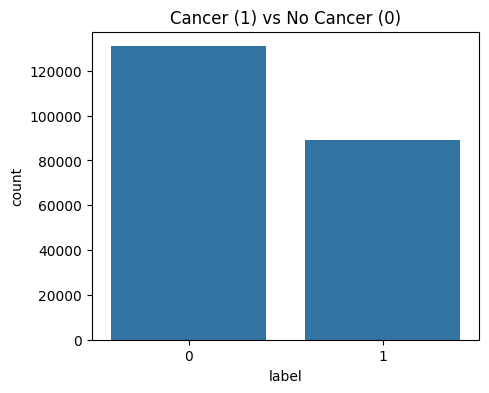

In [4]:
# ------------------------------------------------
# Quick EDA
# ------------------------------------------------
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=train_csv)
plt.title("Cancer (1) vs No Cancer (0)")
plt.show()

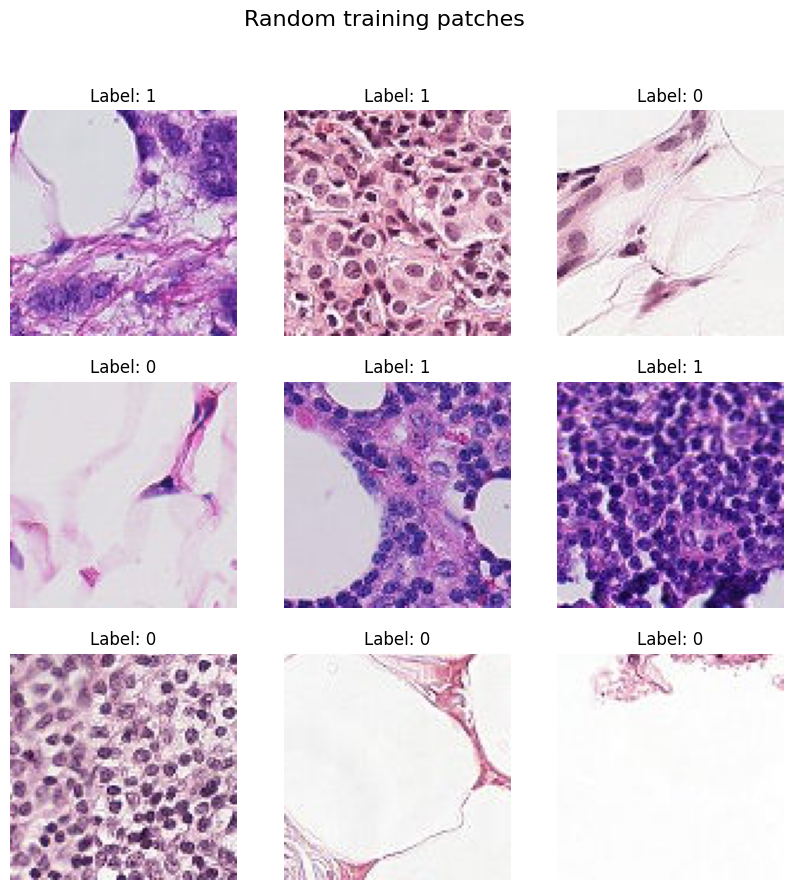

In [5]:
# let’s just look at a few patches
sample_ids = train_csv.sample(9)['id'].values
plt.figure(figsize=(10,10))
for i, img_id in enumerate(sample_ids):
    img_path = os.path.join(DATA_DIR, "train", f"{img_id}.tif")
    img = plt.imread(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    label = train_csv.loc[train_csv['id']==img_id,'label'].values[0]
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.suptitle("Random training patches", fontsize=16)
plt.show()

In [9]:
# ================================================================
# Data pipeline (train/validation split + generators)
# ================================================================
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split into train/validation
train_df, val_df = train_test_split(
    train_csv,
    test_size=0.2,
    stratify=train_csv['label'],
    random_state=42
)

# Add .tif filenames
train_df['filename'] = train_df['id'] + ".tif"
val_df['filename'] = val_df['id'] + ".tif"

# Labels must be strings for class_mode="binary"
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

IMG_SIZE = (96,96)
BATCH_SIZE = 32

# Training data generator (with augmentation)
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20
)

# Validation generator (just rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(DATA_DIR, "train"),
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

# Validation generator
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(DATA_DIR, "train"),
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Training baseline CNN...
Epoch 1/5


/opt/homebrew/Cellar/jupyterlab/4.4.1_1/libexec/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 556s 101ms/step - accuracy: 0.8086 - loss: 0.4294 - val_accuracy: 0.7382 - val_loss: 0.5838
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 820s 149ms/step - accuracy: 0.8560 - loss: 0.3401 - val_accuracy: 0.8398 - val_loss: 0.3679
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 694s 126ms/step - accuracy: 0.8726 - loss: 0.3073 - val_accuracy: 0.8839 - val_loss: 0.2887
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 658s 120ms/step - accuracy: 0.8804 - loss: 0.2904 - val_accuracy: 0.8617 - val_loss: 0.3580
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 726s 132ms/step - accuracy: 0.8851 - loss: 0.2804 - val_accuracy: 0.8824 - val_loss: 0.2841


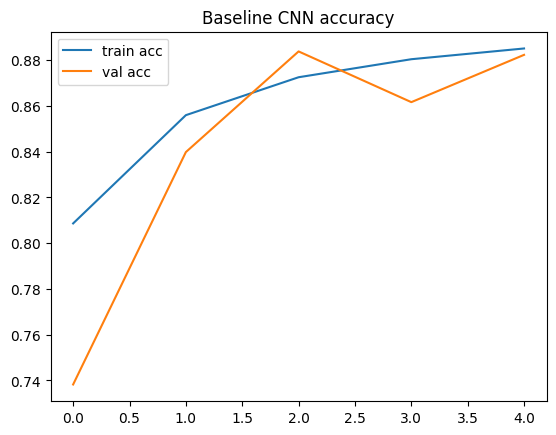

In [10]:
# ------------------------------------------------
# Baseline CNN (super simple model just to have a baseline)
# ------------------------------------------------
baseline = models.Sequential([
    layers.Input(shape=(*IMG_SIZE,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

baseline.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

print("Training baseline CNN...")
history_baseline = baseline.fit(train_gen,
                                validation_data=val_gen,
                                epochs=5)

plt.plot(history_baseline.history['accuracy'], label='train acc')
plt.plot(history_baseline.history['val_accuracy'], label='val acc')
plt.title("Baseline CNN accuracy")
plt.legend()
plt.show()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training ResNet50 (frozen base)...
Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1563s 284ms/step - accuracy: 0.6302 - loss: 0.6405 - val_accuracy: 0.6634 - val_loss: 0.6173
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1606s 292ms/step - accuracy: 0.6930 - loss: 0.5874 - val_accuracy: 0.6735 - val_loss: 0.6068
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1712s 311ms/step - accuracy: 0.7114 - loss: 0.5653 - val_accuracy: 0.6891 - val_loss: 0.5829
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1706s 310ms/step - accuracy: 0.7174 - loss: 0.5544 - val_accuracy: 0.6855 - val_loss: 0.5840
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1642s 298ms/step - accuracy: 0.7240 - loss: 0.5464 - val_accuracy: 0.6965 - val_loss: 0.5766


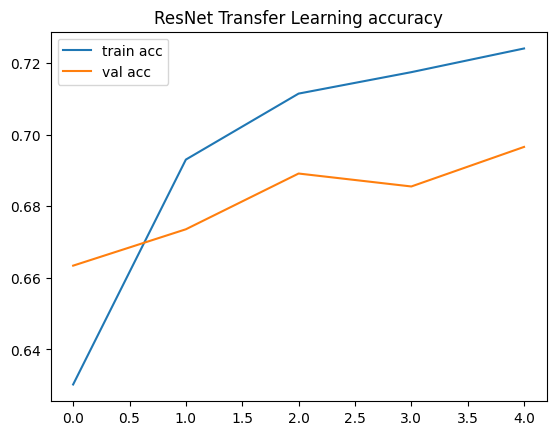

In [11]:
# ------------------------------------------------
# Transfer learning with ResNet50
# ------------------------------------------------
# ResNet is big, but usually works well. Start frozen, then maybe unfreeze later.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base_model.trainable = False

resnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

print("Training ResNet50 (frozen base)...")
history_resnet = resnet_model.fit(train_gen,
                                  validation_data=val_gen,
                                  epochs=5)

# plot training history
plt.plot(history_resnet.history['accuracy'], label='train acc')
plt.plot(history_resnet.history['val_accuracy'], label='val acc')
plt.title("ResNet Transfer Learning accuracy")
plt.legend()
plt.show()


In [14]:
# ------------------------------------------------
# Make predictions for Kaggle submission
# ------------------------------------------------
test_dir = os.path.join(DATA_DIR, "test")
test_ids = os.listdir(test_dir)

# Build dataframe with proper filenames
test_df = pd.DataFrame({
    'id': [f.replace('.tif','') for f in test_ids]
})
test_df['filename'] = test_df['id'] + ".tif"

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="filename",   # must match actual file names
    y_col=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Predictions
preds = resnet_model.predict(
    test_gen,
    verbose=1,
)

test_df['label'] = preds

# Save submission
submission = test_df[['id','label']]
submission.to_csv("submission.csv", index=False)
print("submission.csv written!")


Found 57458 validated image filenames.


/opt/homebrew/Cellar/jupyterlab/4.4.1_1/libexec/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 347s 193ms/step
submission.csv written!
